In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from matplotlib import pyplot as plt
from bin.utils import iterate_fasta, barplot, plot_logo
from Bio import SeqIO
import logomaker
from abnumber import Chain, Position
from matplotlib import ticker

%config InlineBackend.figure_format = 'retina'

In [2]:
SCHEME = 'kabat'
SOURCE_DATA = '../../../oas-dataset/data'
OAS_HIT_DIR = '../../data/tasks/therapeutic_rediscovery/oas_cdr_hits'
MIN_IMGT_CDR_IDENTITY = 0.60


In [60]:
stats = {}
for chain, name in zip('HKL', ['Heavy','Kappa','Lambda']):
    stat = pd.read_csv(f'../../data/oas_stats/imgt_residue_frequency/{name}.tsv', sep='\t', index_col=0)
    stats[chain] = stat.divide(stat.sum(axis=1), axis=0)
stats['H'].head().apply(lambda c: c.apply('{:.1%}'.format))

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
imgt_pos,,,,,,,,,,,,,,,,,,,,
1,0.0%,0.0%,0.4%,31.9%,0.0%,0.0%,0.4%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,67.3%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
2,0.6%,0.0%,0.1%,0.5%,0.1%,0.5%,0.0%,2.4%,0.0%,7.3%,1.0%,0.0%,0.1%,0.0%,0.0%,0.0%,0.0%,87.3%,0.0%,0.0%
3,0.0%,0.0%,0.0%,0.3%,0.0%,0.0%,2.0%,0.0%,0.4%,0.5%,0.0%,0.1%,0.7%,91.3%,0.9%,0.0%,3.6%,0.0%,0.0%,0.1%
4,0.0%,0.0%,0.0%,0.0%,0.1%,0.0%,0.0%,0.1%,0.0%,97.9%,0.3%,0.0%,0.3%,0.1%,0.3%,0.0%,0.0%,0.9%,0.0%,0.0%
5,0.4%,0.0%,0.0%,0.5%,0.1%,0.2%,0.3%,0.1%,3.0%,8.1%,0.3%,0.0%,0.2%,27.1%,0.9%,0.1%,0.1%,58.7%,0.0%,0.0%


In [6]:
mabs = pd.read_csv('../../data/sabdab/TheraSAbDab_clean.tsv', sep='\t', index_col=0)
mabs.head(3)

,Format,Suffix,CH1 Isotype,VD LC,Highest_Clin_Trial (Jan '20),Est. Status,Heavy Sequence,Light Sequence,Heavy Sequence (if bispec),Light Sequence (if bispec),...,95-98% SI Structure,Year Proposed,Year Recommended,Target,Companies,Conditions Approved,Conditions Active,Conditions Discontinued,Development Tech,Notes
Therapeutic,,,,,,,,,,,,,,,,,,,,,
Abagovomab,Whole mAb,-omab,G1,Kappa,Phase-III,Discontinued,QVKLQESGAELARPGASVKLSCKASGYTFTNYWMQWVKQRPGQGLD...,DIELTQSPASLSASVGETVTITCQASENIYSYLAWHQQKQGKSPQL...,NaN,NaN,...,None,2006,2007.0,CA125,Menarini,NaN,NaN,Ovarian cancer;Pancreatic cancer,NaN,NaN
Abelacimab,Whole mAb,-imab,G1,Lambda,Unknown,Unknown,QVQLLESGGGLVQPGGSLRLSCAASGFTFSTAAMSWVRQAPGKGLE...,QSVLTQPPSASGTPGQRVTISCSGSSSNIGSNDVSWYQQLPGTAPK...,NaN,NaN,...,6r8x:CB,2018,2019.0,F11,Novartis,NaN,Thromboembolism,NaN,NaN,NaN
Abituzumab,Whole mAb,-zumab,G2,Kappa,Phase-II,Active,QVQLQQSGGELAKPGASVKVSCKASGYTFSSFWMHWVRQAPGQGLE...,DIQMTQSPSSLSASVGDRVTITCRASQDISNYLAWYQQKPGKAPKL...,NaN,NaN,...,None,2013,2014.0,ITGAV,Merck,NaN,Systemic scleroderma,Colorectal cancer;Ovarian cancer;Prostate canc...,NaN,"4o02 claims to be abituzumab (17E6), but is not"


In [7]:
all_units = pd.read_csv(os.path.join(SOURCE_DATA, 'all/meta/units.tsv'), sep='\t').set_index('UnitPath')
all_units['species_simple'] = all_units['Species'].str.replace('_.*','').str.lower()

# Contains leaked mouse sequences
all_units = all_units[all_units['StudyPath'] != 'Corcoran_2016']

non_human_units = all_units[~all_units['Species'].isin(['human', 'HIS-mouse'])]

non_human_heavy_units = non_human_units[non_human_units['Chain'] == 'Heavy']
non_human_light_units = non_human_units[non_human_units['Chain'] == 'Light']
print(f'Loaded {len(non_human_heavy_units):,} non-human heavy units and {len(non_human_light_units):,} non-human light units')

human_units = all_units[all_units['Species'].isin(['human'])]

human_heavy_units = human_units[human_units['Chain'] == 'Heavy']
human_light_units = human_units[human_units['Chain'] == 'Light']
print(f'Loaded {len(human_heavy_units):,} human heavy units and {len(human_light_units):,} human light units')

Loaded 411 non-human heavy units and 45 non-human light units
Loaded 6,034 human heavy units and 273 human light units


In [8]:
all_units['species_simple'].str.replace('_.*','').value_counts()

human        6307
mouse         384
rat            56
his-mouse      12
rabbit          7
camel           6
rhesus          3
Name: species_simple, dtype: int64

In [9]:
def merge_hits(units, query_chains, hit_dir):
    best_hits = {}
    missing = 0
    
    incomplete = 0
    total = 0
    
    query_chains = query_chains.apply(Chain.renumber, scheme='imgt') 
        
    for unit_path, unit in units.iterrows():
        path = os.path.join(hit_dir, unit['StudyPath'], unit_path+'.csv')
        if not os.path.exists(path):
            missing += 1
            continue
        hits = pd.read_csv(path).set_index('Id', verify_integrity=True)
        if len(hits) == 0:
            continue
        position_columns = [col_name for col_name in hits.columns if col_name[0].isnumeric()]
        for name, hit in hits.iterrows():
            total += 1
            if name not in query_chains.index:
                continue
            hit_fw_matches = hit['num_fw_matches']
            hit_cdr_matches = hit['num_cdr_matches']
            if name in best_hits:
                best_fw_matches = best_hits[name]['imgt_fw_matches']
                best_cdr_matches = best_hits[name]['imgt_cdr_matches']
                if hit_cdr_matches < best_cdr_matches:
                    continue
                if hit_cdr_matches == best_cdr_matches and hit_fw_matches <= best_fw_matches:
                    continue
            query = query_chains.loc[name]
            aligned = query.align(Chain.from_series(hit, scheme='imgt'))
            aligned_len = len(aligned)
            aligned_cdr_len = sum(pos.is_in_cdr() for pos, _ in aligned)
            aligned_fw_len = aligned_len - aligned_cdr_len
            imgt_cdr_identity = hit_cdr_matches / aligned_cdr_len
            imgt_fw_identity = hit_fw_matches / aligned_fw_len
            full_identity = hit['num_full_matches'] / aligned_len
            seq = ''.join(hit[position_columns]).replace('-','')
            best_hits[name] = {
                'imgt_cdr_matches': hit_cdr_matches,
                'imgt_fw_matches': hit_fw_matches,
                'imgt_cdr_identity': imgt_cdr_identity,
                'imgt_fw_identity': imgt_fw_identity,
                'full_identity': full_identity,
                'species': hit['species'],
                'hit_name': hit['hit_name'],
                'hit_seq': seq,
                'hit_unit': unit_path,
                'hit_study': unit['StudyPath']
            }
    best_hits = pd.DataFrame.from_dict(best_hits, orient='index').sort_index()
    
    if missing:
        print(f'\nWarning: {missing}/{len(units)} units were missing!')
        
    if incomplete:
        print(f'\nWarning: Skipped {incomplete:,}/{total:,} candidate hits with incomplete sequences!')

    return best_hits


# Heavy chain

In [7]:
query_heavy_chains = Chain.from_anarci_csv(f'../../data/tasks/therapeutic_rediscovery/thera/humanized_{SCHEME}_H.csv', scheme=SCHEME, as_series=True)

query_heavy_chains.head()

Abituzumab      ((H1, Q), (H2, V), (H3, Q), (H4, L), (H5, Q), ...
Afutuzumab      ((H1, Q), (H2, V), (H3, Q), (H4, L), (H5, V), ...
Alacizumab      ((H1, E), (H2, V), (H3, Q), (H4, L), (H5, V), ...
Alemtuzumab     ((H1, Q), (H2, V), (H3, Q), (H4, L), (H5, Q), ...
Anrukinzumab    ((H1, E), (H2, V), (H3, Q), (H4, L), (H5, V), ...
dtype: object

In [11]:
heavy_hits = merge_hits(non_human_heavy_units, query_heavy_chains, os.path.join(OAS_HIT_DIR, 'heavy'))

print('Best CDR matches:')
heavy_hits.sort_values(['imgt_cdr_identity'], ascending=False).head()

Best CDR matches:


,imgt_cdr_matches,imgt_fw_matches,imgt_cdr_identity,imgt_fw_identity,full_identity,species,hit_name,hit_seq,hit_unit,hit_study
Tadocizumab,27,72,0.964286,0.791209,0.831933,mouse,169882,QVQLKESGAELVRPGTSVKVSCKASGYAFTNYLIEWVKQRPGQGLE...,Greiff_2014_one_mouse_one_mouse_merged_igblastn,Greiff_2014
Sacituzumab,28,73,0.933333,0.802198,0.834711,mouse,124441,QIQLVQSGPELKKPGETVKISCKASGYTFTNYGMNWVKQAPGKGLK...,Khan_2016_Unimmunized_mouse_2_Unimmunized_mous...,Khan_2016
Simtuzumab,23,77,0.920000,0.846154,0.862069,mouse,3925394,VQLQQSGAELVRPGTSVKVSCKASGYAFTNYLIEWVKQRPGQGLEW...,Greiff_2017_NP-HEL_mouse_5_naive_B_cell_IGHM_N...,Greiff_2017
Natalizumab,29,69,0.906250,0.758242,0.796748,mouse,134825,VQLQQSGAELVKPGASVKLSCTASGFNIKDTYMHWVKQRPEQGLEW...,Greiff_2017_pet_mouse_1_naive_B_cell_IGHM_pet_...,Greiff_2017
Ocrelizumab,29,59,0.906250,0.648352,0.715447,mouse,1654076,QVQLQQSGAELVRPGASVKMSCKASGYTFTSYNMHWVKQTPRQGLE...,Greiff_2017_C57BL_mouse_4_pre-B_cell_bone_marr...,Greiff_2017


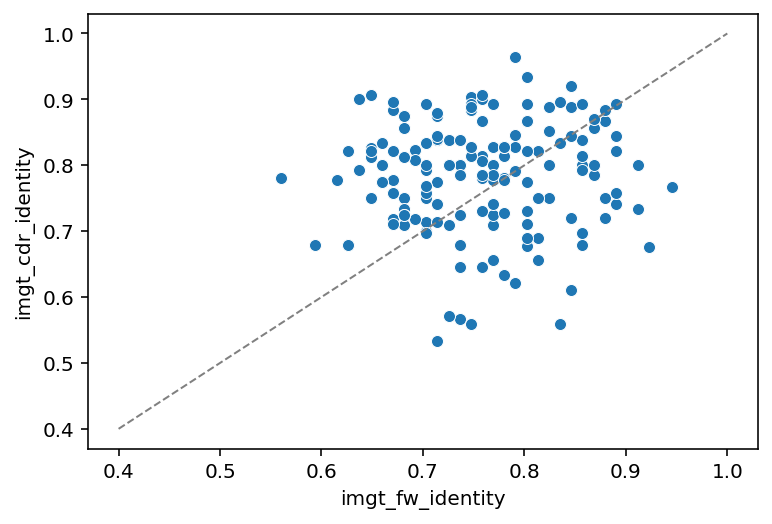

In [12]:
ax = sns.scatterplot(data=heavy_hits, x='imgt_fw_identity', y='imgt_cdr_identity');
ax.plot([0.4, 1], [0.4, 1], ls='--', lw=1, color='grey');

In [13]:
heavy_human_hits = merge_hits(human_heavy_units, query_heavy_chains, os.path.join(OAS_HIT_DIR, 'heavy'))

heavy_human_hits.sort_values(['imgt_cdr_identity'], ascending=False).head(5)

,imgt_cdr_matches,imgt_fw_matches,imgt_cdr_identity,imgt_fw_identity,full_identity,species,hit_name,hit_seq,hit_unit,hit_study
Tibulizumab,31,91,0.968750,1.000000,0.991870,rhesus,SRR5811763.3170326 3170326,QVQLQQWGAGLLKPSETLSLTCAVYGGSFSGYYWSWIRQPPGKGLE...,Waltari_2018_Heavy_Healthy_PBMCs_IGHM_Heavy_He...,Waltari_2018
Vanucizumab,35,75,0.921053,0.824176,0.852713,human,ad403400-b3bf-4440-b710-6162d4a166f9_1,SVKVSCKASGYTFTGYYMHWVRQAPGQGLEWMGWINPNSGGTNYAQ...,Briney_2019_Subject_326780_IgM_Subject-326780_...,Briney_2019
Denintuzumab,25,56,0.833333,0.615385,0.669421,human,fb791e45-40fe-4887-b988-b042936ff4a2_1,ESGPTLVNPTQTLTLTCTFSGFSLSTSGMGVSWIRQPPVKALEWLA...,Briney_2019_Subject_326650_IgM_Subject-326650_...,Briney_2019
Zenocutuzumab,28,75,0.823529,0.824176,0.824000,human,678a51ea-c290-4eb5-9951-5ee9838a7291_17,SVKVSCKASGYTFTGYYMHWVRQAPGQGLEWMGWINPNSGGTNYAQ...,Briney_2019_Subject_326651_IgM_Subject-326651_...,Briney_2019
Ficlatuzumab,22,71,0.814815,0.780220,0.788136,human,Query_105530,SGAEVKKPGASVKVSCKASGYTFTTYYIHWVRQAPGQGLEWMGMIN...,Jiang_2013_FLU_IGHG_SRR747758_iglblastn_igblas...,Jiang_2013


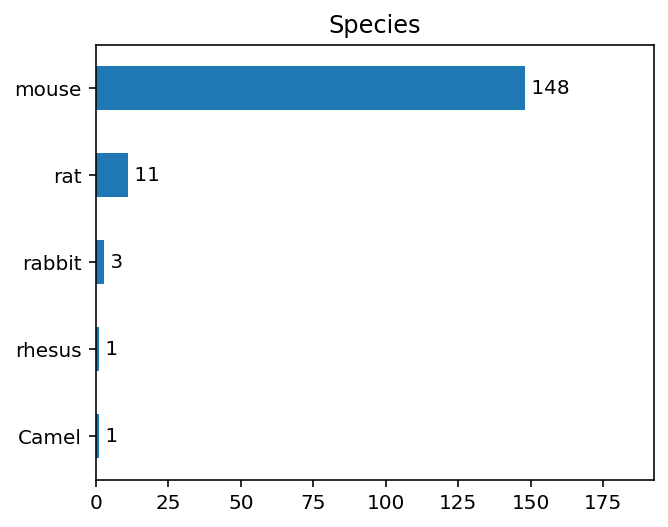

In [14]:
heavy_species = pd.Series(all_units.loc[heavy_hits['hit_unit']]['Species'].str.replace('_.*','').values, heavy_hits.index, name='Species')
barplot(heavy_species.value_counts(), figsize=(5, 4));

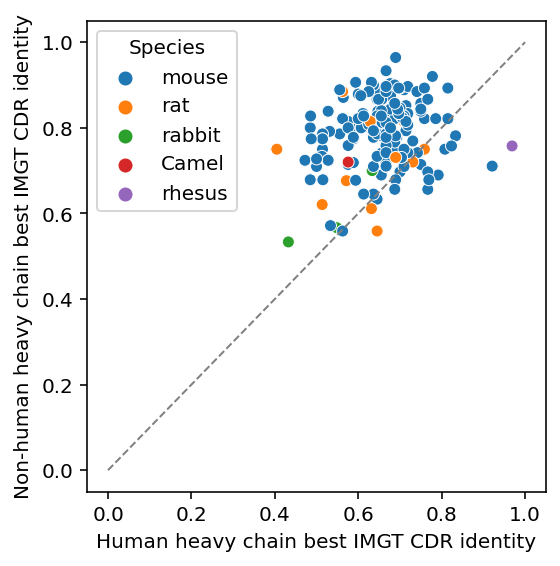

In [15]:
fig, ax = plt.subplots(figsize=(4, 4))

ax = sns.scatterplot(x=heavy_human_hits['imgt_cdr_identity'], y=heavy_hits['imgt_cdr_identity'], hue=heavy_species, ax=ax)
ax.set_xlabel('Human heavy chain best IMGT CDR identity')
ax.set_ylabel('Non-human heavy chain best IMGT CDR identity')
ax.plot([0, 1], [0, 1], ls='--', lw=1, color='grey');

fig.tight_layout()

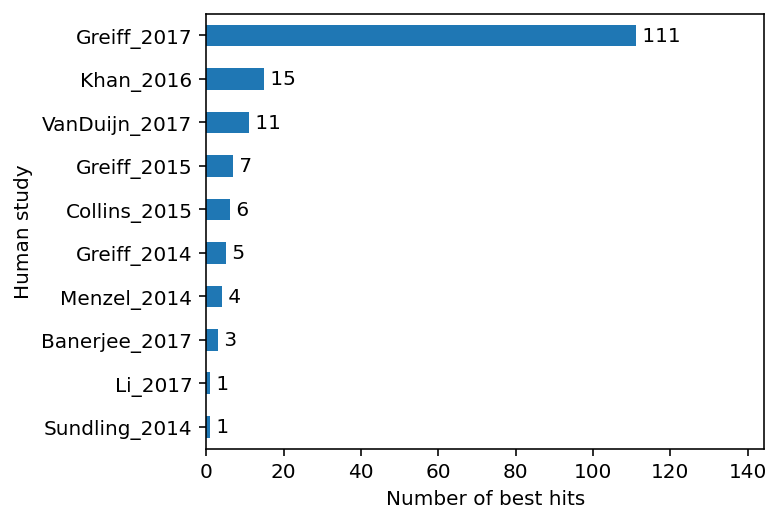

In [16]:
ax = barplot(heavy_hits['hit_study'].value_counts(), figsize=(5, 4));
ax.set_xlabel('Number of best hits')
ax.set_ylabel('Human study');
ax.set_title('');

In [17]:
hit_heavy_chains = pd.Series({name: Chain(hit['hit_seq'], scheme=SCHEME, name=name) for name, hit in heavy_hits.iterrows()})
hit_heavy_chains.head()

Abituzumab      ((H1, Q), (H2, V), (H3, Q), (H4, L), (H5, Q), ...
Afutuzumab      ((H1, Q), (H2, V), (H3, Q), (H4, L), (H5, Q), ...
Alacizumab      ((H1, E), (H2, V), (H3, K), (H4, L), (H5, V), ...
Alemtuzumab     ((H1, D), (H2, V), (H3, M), (H4, L), (H5, V), ...
Anrukinzumab    ((H1, E), (H2, V), (H3, Q), (H4, L), (H5, V), ...
dtype: object

In [94]:
def get_human_frequency_in_chain_type(chain):
    if chain.scheme != 'imgt':
        chain = chain.renumber('imgt')
    positions = [pos.format(chain_type=False) for pos in chain.positions]
    s = stats[chain.chain_type]
    return [s.loc[pos_str, aa] if pos_str in s.index else np.nan for pos_str, aa in zip(positions, chain.seq)]

def backgraft_chain(query, hit, preserve_rare_residue=0.01, fill_missing_edge=2, verbose=False):
    backmutations = []
    if preserve_rare_residue:
        frequency = get_human_frequency_in_chain_type(query)
        for f, pos in zip(frequency, query.positions):
            if f < preserve_rare_residue:
                backmutations.append(pos)
        if verbose:
            print(f'Keeping {len(backmutations):,} rare residues: {backmutations}')
    
    #print(query.name)
    #print(''.join('C' if pos.is_in_cdr() else ('B' if pos in backmutations else ' ') for pos in query.positions))
    #print(query.align(hit))

    if fill_missing_edge:
        if hit.raw[fill_missing_edge] == '-' or hit.raw[-fill_missing_edge] == '-':
            raise ValueError(f'Hit is too incomplete:\n{hit}')
        aligned = query.align(hit)
        for pos, (aa, bb) in aligned.raw[:5]:
            if bb == '-':
                backmutations.append(pos)
        for pos, (aa, bb) in aligned.raw[-5:]:
            if bb == '-':
                backmutations.append(pos)
                                
    return query.graft_cdrs_onto(hit, backmutations=backmutations)
    

In [95]:
parental_heavy_chains = pd.Series({name: backgraft_chain(query, hit_heavy_chains.loc[name], verbose=True) 
                                  for name, query in query_heavy_chains.items()})
parental_heavy_chains.head()

Keeping 4 rare residues: [H12 (kabat), H62 (kabat), H66 (kabat), H67 (kabat)]
Keeping 4 rare residues: [H28 (kabat), H31 (kabat), H61 (kabat), H101 (kabat)]
Keeping 0 rare residues: []
Keeping 4 rare residues: [H53 (kabat), H55 (kabat), H70 (kabat), H107 (kabat)]
Keeping 1 rare residues: [H60 (kabat)]
Keeping 0 rare residues: []
Keeping 1 rare residues: [H62 (kabat)]
Keeping 3 rare residues: [H33 (kabat), H62 (kabat), H67 (kabat)]
Keeping 7 rare residues: [H33 (kabat), H40 (kabat), H62 (kabat), H66 (kabat), H71 (kabat), H91 (kabat), H93 (kabat)]
Keeping 3 rare residues: [H62 (kabat), H65 (kabat), H69 (kabat)]
Keeping 2 rare residues: [H33 (kabat), H60 (kabat)]
Keeping 6 rare residues: [H30 (kabat), H32 (kabat), H34 (kabat), H54 (kabat), H61 (kabat), H100 (kabat)]
Keeping 1 rare residues: [H53 (kabat)]
Keeping 3 rare residues: [H32 (kabat), H62 (kabat), H63 (kabat)]
Keeping 3 rare residues: [H35 (kabat), H50 (kabat), H52 (kabat)]
Keeping 2 rare residues: [H35 (kabat), H50 (kabat)]
Keepi

Abituzumab      ((H1, Q), (H2, V), (H3, Q), (H4, L), (H5, Q), ...
Afutuzumab      ((H1, Q), (H2, V), (H3, Q), (H4, L), (H5, Q), ...
Alacizumab      ((H1, E), (H2, V), (H3, K), (H4, L), (H5, V), ...
Alemtuzumab     ((H1, D), (H2, V), (H3, M), (H4, L), (H5, V), ...
Anrukinzumab    ((H1, E), (H2, V), (H3, Q), (H4, L), (H5, V), ...
dtype: object

In [96]:
heavy_hits.loc['Abituzumab'][:8]

imgt_cdr_matches                                                    23
imgt_fw_matches                                                     75
imgt_cdr_identity                                             0.851852
imgt_fw_identity                                              0.824176
full_identity                                                 0.830508
species                                                          mouse
hit_name                                                        556777
hit_seq              QVQLQQSGAELAKPGASVKLSCKASGYTFTSYWMHWVKQRPGQGLE...
Name: Abituzumab, dtype: object

In [97]:
query_heavy_chains.loc['Abituzumab'].align(hit_heavy_chains.loc['Abituzumab'])

QVQLQQSGGELAKPGASVKVSCKASGYTFSSFWMHWVRQAPGQGLEWIGYINPRSGYTEYNEIFRDKATMTTDTSTSTAYMELSSLRSEDTAVYYCASFLGRGAMDYWGQGTTVTVSS
||||||||.||||||||||+|||||||||+|+|||||+|.|||||||||||||.||||+||+.|+||||+|.|.|+|||||+||||.|||+||||||.||||||||||||||+|||||
QVQLQQSGAELAKPGASVKLSCKASGYTFTSYWMHWVKQRPGQGLEWIGYINPSSGYTKYNQKFKDKATLTADKSSSTAYMQLSSLTSEDSAVYYCARFLGRGAMDYWGQGTSVTVSS
 °                        °°°°^^^^^           °°°^^^^^^^^^^^^^^^^^ ° ° ° °    °                 °°^^^^^^^^^°          

In [98]:
query_heavy_chains.loc['Abituzumab'].align(parental_heavy_chains.loc['Abituzumab'])

QVQLQQSGGELAKPGASVKVSCKASGYTFSSFWMHWVRQAPGQGLEWIGYINPRSGYTEYNEIFRDKATMTTDTSTSTAYMELSSLRSEDTAVYYCASFLGRGAMDYWGQGTTVTVSS
||||||||.||||||||||+|||||||||+|||||||+|.|||||||||||||||||||||||||||||+|.|.|+|||||+||||.|||+||||||.||||||||||||||+|||||
QVQLQQSGAELAKPGASVKLSCKASGYTFTSFWMHWVKQRPGQGLEWIGYINPRSGYTEYNEIFRDKATLTADKSSSTAYMQLSSLTSEDSAVYYCARFLGRGAMDYWGQGTSVTVSS
 °                        °°°°^^^^^           °°°^^^^^^^^^^^^^^^^^ ° ° ° °    °                 °°^^^^^^^^^°          

In [99]:
hit_heavy_chains.loc['Abituzumab'].align(parental_heavy_chains.loc['Abituzumab'])

QVQLQQSGAELAKPGASVKLSCKASGYTFTSYWMHWVKQRPGQGLEWIGYINPSSGYTKYNQKFKDKATLTADKSSSTAYMQLSSLTSEDSAVYYCARFLGRGAMDYWGQGTSVTVSS
|||||||||||||||||||||||||||||||+|||||||||||||||||||||.||||+||+.|+|||||||||||||||||||||||||||||||||||||||||||||||||||||
QVQLQQSGAELAKPGASVKLSCKASGYTFTSFWMHWVKQRPGQGLEWIGYINPRSGYTEYNEIFRDKATLTADKSSSTAYMQLSSLTSEDSAVYYCARFLGRGAMDYWGQGTSVTVSS
 °                        °°°°^^^^^           °°°^^^^^^^^^^^^^^^^^ ° ° ° °    °                 °°^^^^^^^^^°          

# Light chain

In [8]:
query_light_chains = Chain.from_anarci_csv(f'../../data/tasks/therapeutic_rediscovery/thera/humanized_{SCHEME}_KL.csv', scheme=SCHEME, as_series=True)

query_light_chains.head()

Abituzumab      ((L1, D), (L2, I), (L3, Q), (L4, M), (L5, T), ...
Afutuzumab      ((L1, D), (L2, I), (L3, V), (L4, M), (L5, T), ...
Alacizumab      ((L1, D), (L2, I), (L3, Q), (L4, M), (L5, T), ...
Alemtuzumab     ((L1, D), (L2, I), (L3, Q), (L4, M), (L5, T), ...
Anrukinzumab    ((L1, D), (L2, I), (L3, Q), (L4, M), (L5, T), ...
dtype: object

In [25]:
light_hits = merge_hits(non_human_light_units, query_light_chains, os.path.join(OAS_HIT_DIR, 'light'))

print('Best CDR hits:')
light_hits.sort_values(['imgt_cdr_identity'], ascending=False).head()

Best CDR hits:


,imgt_cdr_matches,imgt_fw_matches,imgt_cdr_identity,imgt_fw_identity,full_identity,species,hit_name,hit_seq,hit_unit,hit_study
Abituzumab,18,70,1.0,0.786517,0.822430,mouse,484748,DIQMTQTTSSLSASLGDRVTISCRASQDISNYLNWYQQKPDGTIKL...,Cui_2016_control1_control_mouse_1_iglblastn,Cui_2016
Flotetuzumab,24,81,1.0,0.910112,0.929204,mouse,56885,DIVMTQSPSSLAVSAGEKVTMSCKSSQSLLNSGNQKNYLTWYQQKP...,Fisher_2017_Light_Naive_IAC2_Naive_Light_iglbl...,Fisher_2017
Ozanezumab,23,78,1.0,0.876404,0.901786,mouse,1143802,DIVITQDELSNPVTSGESVSISCRSSKSLLYKDGKTYLNWFLQRPG...,Cui_2016_control1_control_mouse_1_iglblastn,Cui_2016
Crenezumab,23,79,1.0,0.887640,0.910714,rhesus,142955,DIVMTQSPLSLPVSLGDQASISCSSSQSLVYSNGDTYLHWYLQKPG...,Fisher_2017_Light_Plasmodium_IAC5_Plasmodium_L...,Fisher_2017
Omalizumab,22,66,1.0,0.741573,0.792793,mouse,Query_2347162,DIVLTQSPASLAVSLGQRATISCKASQSVDYDGDSYMNWYQQKPGQ...,Rettig_2018_Light_whole_spleen_Bulk_whole_sple...,Rettig_2018


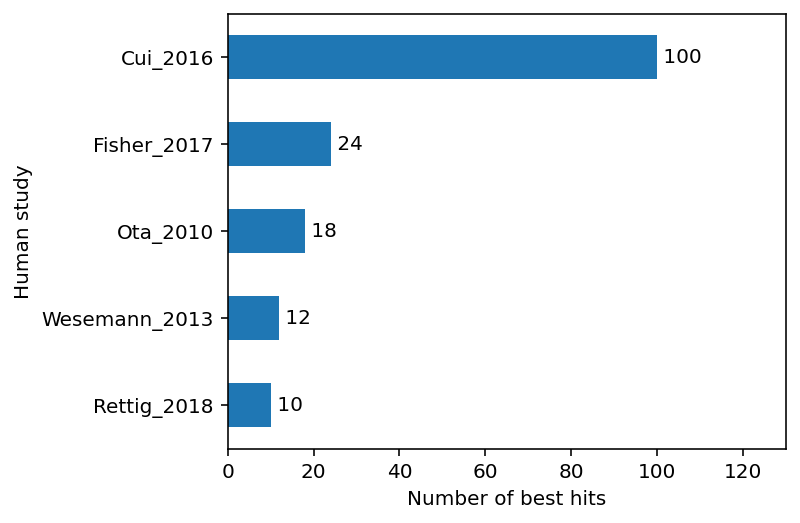

In [26]:
ax = barplot(light_hits['hit_study'].value_counts(), figsize=(5, 4));
ax.set_xlabel('Number of best hits')
ax.set_ylabel('Human study');
ax.set_title('');

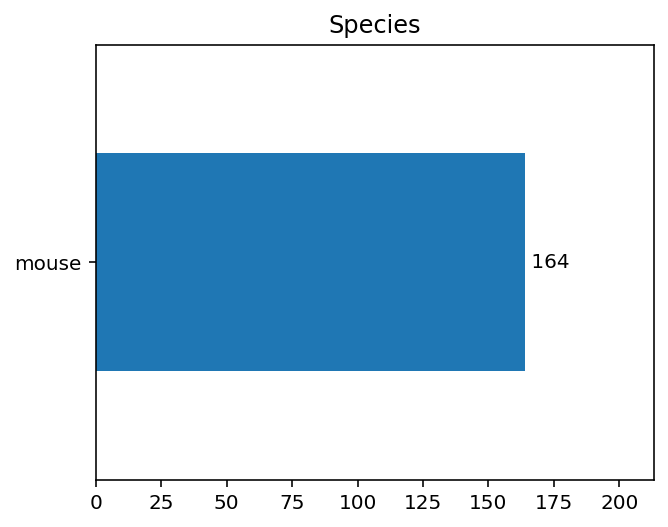

In [27]:
light_species = pd.Series(all_units.loc[light_hits['hit_unit']]['Species'].str.replace('_.*','').values, light_hits.index, name='Species')
barplot(light_species.value_counts(), figsize=(5, 4));

In [28]:
light_human_hits = merge_hits(human_light_units, query_light_chains, os.path.join(OAS_HIT_DIR, 'light'))

light_human_hits.sort_values(['imgt_cdr_identity'], ascending=False).head(5)

,imgt_cdr_matches,imgt_fw_matches,imgt_cdr_identity,imgt_fw_identity,full_identity,species,hit_name,hit_seq,hit_unit,hit_study
Zenocutuzumab,18,89,1.000000,1.000000,1.000000,human,SRR5811758.3729185 3729185,DIQMTQSPSSLSASVGDRVTITCRASQSISSYLNWYQQKPGKAPKL...,Waltari_2018_Light_Healthy_PBMCs_Bulk_Heavy_He...,Waltari_2018
Vanucizumab,20,86,1.000000,0.977273,0.981481,human,ERR2567251.840599 M00619:258:000000000-ARB60:1...,SSGLTQPPSVSVAPGQTARITCGGNNIGSKSVHWYQQKPGQAPVLV...,Gidoni_2019_Light_Healthy-celiac-disease_Bulk_...,Gidoni_2019
Tibulizumab,18,88,1.000000,0.988764,0.990654,human,SRR5811758.6369974 6369974,EIVLTQSPATLSLSPGERATLSCRASQSVSRYLAWYQQKPGQAPRL...,Waltari_2018_Light_Healthy_PBMCs_Bulk_Heavy_He...,Waltari_2018
Vandortuzumab,22,73,0.916667,0.820225,0.840708,rhesus,SRR5811771.2148485 2148485,DIVMTQSPDSLAVSLGERATINCKSSQSLLYRSNKKNYLAWYQQKP...,Waltari_2018_Light_Healthy_PBMCs_Bulk_Heavy_He...,Waltari_2018
Bevacizumab,16,80,0.888889,0.898876,0.897196,human,572384,DIQMTQSPSSLSASVGDRVTITCRASQDISNYLAWFQQKPGKAPKS...,Zhou_2013_RU3_VK1_2_iglblastn,Zhou_2013


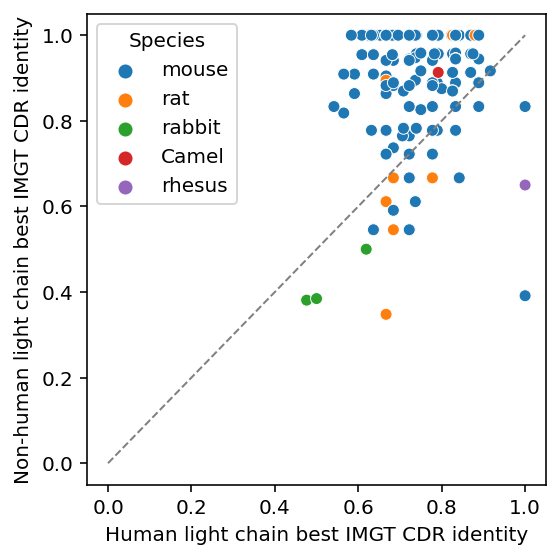

In [29]:
fig, ax = plt.subplots(figsize=(4, 4))

ax = sns.scatterplot(x=light_human_hits['imgt_cdr_identity'], y=light_hits['imgt_cdr_identity'], hue=heavy_species, ax=ax)
ax.set_xlabel('Human light chain best IMGT CDR identity')
ax.set_ylabel('Non-human light chain best IMGT CDR identity')
ax.plot([0, 1], [0, 1], ls='--', lw=1, color='grey');

fig.tight_layout()

In [30]:
hit_light_chains = pd.Series({name: Chain(hit['hit_seq'], scheme=SCHEME, name=name) for name, hit in light_hits.iterrows()})
hit_light_chains.head()

Abituzumab      ((L1, D), (L2, I), (L3, Q), (L4, M), (L5, T), ...
Afutuzumab      ((L1, D), (L2, I), (L3, V), (L4, M), (L5, T), ...
Alacizumab      ((L1, D), (L2, I), (L3, Q), (L4, M), (L5, T), ...
Alemtuzumab     ((L1, D), (L2, I), (L3, K), (L4, L), (L5, I), ...
Anrukinzumab    ((L1, D), (L2, I), (L3, V), (L4, L), (L5, T), ...
dtype: object

In [100]:
parental_light_chains = pd.Series({name: backgraft_chain(query, hit_light_chains.loc[name], verbose=True) 
                                  for name, query in query_light_chains.items()})
parental_light_chains.head()

Keeping 5 rare residues: [L50 (kabat), L53 (kabat), L54 (kabat), L55 (kabat), L71 (kabat)]
Keeping 8 rare residues: [L27 (kabat), L30 (kabat), L50 (kabat), L51 (kabat), L55 (kabat), L89 (kabat), L91 (kabat), L93 (kabat)]
Keeping 8 rare residues: [L30 (kabat), L31 (kabat), L36 (kabat), L44 (kabat), L60 (kabat), L66 (kabat), L69 (kabat), L71 (kabat)]
Keeping 4 rare residues: [L30 (kabat), L31 (kabat), L50 (kabat), L52 (kabat)]
Keeping 10 rare residues: [L27 (kabat), L27C (kabat), L27D (kabat), L28 (kabat), L32 (kabat), L33 (kabat), L34 (kabat), L50 (kabat), L93 (kabat), L94 (kabat)]
Keeping 7 rare residues: [L32 (kabat), L50 (kabat), L53 (kabat), L55 (kabat), L93 (kabat), L94 (kabat), L96 (kabat)]
Keeping 3 rare residues: [L36 (kabat), L53 (kabat), L89 (kabat)]
Keeping 3 rare residues: [L50 (kabat), L53 (kabat), L55 (kabat)]
Keeping 5 rare residues: [L24 (kabat), L25 (kabat), L27 (kabat), L30 (kabat), L50 (kabat)]
Keeping 4 rare residues: [L24 (kabat), L50 (kabat), L55 (kabat), L94 (kaba

Abituzumab      ((L1, D), (L2, I), (L3, Q), (L4, M), (L5, T), ...
Afutuzumab      ((L1, D), (L2, I), (L3, V), (L4, M), (L5, T), ...
Alacizumab      ((L1, D), (L2, I), (L3, Q), (L4, M), (L5, T), ...
Alemtuzumab     ((L1, D), (L2, I), (L3, K), (L4, L), (L5, I), ...
Anrukinzumab    ((L1, D), (L2, I), (L3, V), (L4, L), (L5, T), ...
dtype: object

In [101]:
light_hits.loc['Abituzumab'][:8]

imgt_cdr_matches                                                    18
imgt_fw_matches                                                     70
imgt_cdr_identity                                                    1
imgt_fw_identity                                              0.786517
full_identity                                                  0.82243
species                                                          mouse
hit_name                                                        484748
hit_seq              DIQMTQTTSSLSASLGDRVTISCRASQDISNYLNWYQQKPDGTIKL...
Name: Abituzumab, dtype: object

In [102]:
query_light_chains.loc['Abituzumab'].align(hit_light_chains.loc['Abituzumab'])

DIQMTQSPSSLSASVGDRVTITCRASQDISNYLAWYQQKPGKAPKLLIYYTSKIHSGVPSRFSGSGSGTDYTFTISSLQPEDIATYYCQQGNTFPYTFGQGTKVEIK
||||||+.||||||+||||||+|||||||||||.||||||....||||||||++|||||||||||||||||+.|||+|+.||||||+||||||||||||.|||+|||
DIQMTQTTSSLSASLGDRVTISCRASQDISNYLNWYQQKPDGTIKLLIYYTSRLHSGVPSRFSGSGSGTDYSLTISNLEQEDIATYFCQQGNTFPYTFGGGTKLEIK
 ° °                   ^^^^^^^^^^^°°         °°°°^^^^^^^       ° ° °° °                 ^^^^^^^^^°         

In [103]:
query_light_chains.loc['Abituzumab'].align(parental_light_chains.loc['Abituzumab'])

DIQMTQSPSSLSASVGDRVTITCRASQDISNYLAWYQQKPGKAPKLLIYYTSKIHSGVPSRFSGSGSGTDYTFTISSLQPEDIATYYCQQGNTFPYTFGQGTKVEIK
||||||+.||||||+||||||+||||||||||||||||||....|||||||||||||||||||||||||||+.|||+|+.||||||+||||||||||||.|||+|||
DIQMTQTTSSLSASLGDRVTISCRASQDISNYLAWYQQKPDGTIKLLIYYTSKIHSGVPSRFSGSGSGTDYSLTISNLEQEDIATYFCQQGNTFPYTFGGGTKLEIK
 ° °                   ^^^^^^^^^^^°°         °°°°^^^^^^^       ° ° °° °                 ^^^^^^^^^°         

In [104]:
hit_light_chains.loc['Abituzumab'].align(parental_light_chains.loc['Abituzumab'])

DIQMTQTTSSLSASLGDRVTISCRASQDISNYLNWYQQKPDGTIKLLIYYTSRLHSGVPSRFSGSGSGTDYSLTISNLEQEDIATYFCQQGNTFPYTFGGGTKLEIK
|||||||||||||||||||||||||||||||||.||||||||||||||||||++|||||||||||||||||||||||||||||||||||||||||||||||||||||
DIQMTQTTSSLSASLGDRVTISCRASQDISNYLAWYQQKPDGTIKLLIYYTSKIHSGVPSRFSGSGSGTDYSLTISNLEQEDIATYFCQQGNTFPYTFGGGTKLEIK
 ° °                   ^^^^^^^^^^^°°         °°°°^^^^^^^       ° ° °° °                 ^^^^^^^^^°         

# Save hits

In [176]:
heavy_low_identity = heavy_hits[heavy_hits['imgt_cdr_identity'] < MIN_IMGT_CDR_IDENTITY]
light_low_identity = light_hits[light_hits['imgt_cdr_identity'] < MIN_IMGT_CDR_IDENTITY]
low_identity = pd.concat([heavy_low_identity, light_low_identity]).index.drop_duplicates()
print('Removing', len(low_identity))
low_identity

Removing 12


Index(['Brolucizumab', 'Eptinezumab', 'Olokizumab', 'Plozalizumab',
       'Ponezumab', 'Bimekizumab', 'Clazakizumab', 'Cusatuzumab',
       'Etrolizumab', 'Lodelcizumab', 'Vanucizumab', 'Xentuzumab'],
      dtype='object')

In [177]:
keep_index = heavy_hits.index[~heavy_hits.index.isin(low_identity)]
print('Keeping', len(keep_index))

Keeping 152


In [178]:
heavy_hits.to_csv(os.path.join(OAS_HIT_DIR, 'hits_H.csv'))
light_hits.to_csv(os.path.join(OAS_HIT_DIR, 'hits_KL.csv'))

In [179]:
with open(os.path.join(OAS_HIT_DIR, 'hits.fa'), 'w') as f:
    for heavy, light in zip(hit_heavy_chains.loc[keep_index], hit_light_chains.loc[keep_index]):
        Chain.to_fasta(heavy, f, description='VH')
        Chain.to_fasta(light, f, description='VL')

In [180]:
with open(os.path.join(OAS_HIT_DIR, 'parental.fa'), 'w') as f:
    for heavy, light in zip(parental_heavy_chains.loc[keep_index], parental_light_chains.loc[keep_index]):
        Chain.to_fasta(heavy, f, description='VH')
        Chain.to_fasta(light, f, description='VL')

# Combined Heavy and Light chain

In [156]:
cols = ['hit_unit','hit_study','imgt_cdr_identity','imgt_fw_identity','full_identity']
hits = heavy_hits[cols].add_prefix('heavy.').join(light_hits[cols].add_prefix('light.'), how='inner')
hits.head()

,heavy.hit_unit,heavy.hit_study,heavy.imgt_cdr_identity,heavy.imgt_fw_identity,heavy.full_identity,light.hit_unit,light.hit_study,light.imgt_cdr_identity,light.imgt_fw_identity,light.full_identity
Abituzumab,Greiff_2017_pet_mouse_3_naive_B_cell_IGHM_pet_...,Greiff_2017,0.851852,0.824176,0.830508,Cui_2016_control1_control_mouse_1_iglblastn,Cui_2016,1.000000,0.786517,0.822430
Afutuzumab,Greiff_2015_naive_b_IGM_naive_b_igblastn,Greiff_2015,0.785714,0.769231,0.773109,Rettig_2018_Light_normal_mouse_Bulk_normal_mou...,Rettig_2018,1.000000,0.887640,0.910714
Alacizumab,Greiff_2017_Balb_mouse_2_naive_B_cell_IGHM_nai...,Greiff_2017,0.696970,0.857143,0.814516,Rettig_2018_Light_whole_spleen_Bulk_whole_sple...,Rettig_2018,0.833333,0.820225,0.822430
Alemtuzumab,Greiff_2017_C57BL_mouse_5_naive_B_cell_IGHM_C5...,Greiff_2017,0.781250,0.560440,0.617886,Cui_2016_control2_control_mouse_2_iglblastn,Cui_2016,0.611111,0.685393,0.672897
Anrukinzumab,Greiff_2017_pet_mouse_3_naive_B_cell_IGHM_pet_...,Greiff_2017,0.857143,0.868132,0.865546,Cui_2016_control2_control_mouse_2_iglblastn,Cui_2016,0.909091,0.741573,0.774775


In [157]:
(hits['heavy.hit_study'] == hits['light.hit_study']).sum()

0

In [158]:
species_pairs = 'heavy: ' + heavy_species + ', light: ' + light_species
species_pairs.value_counts()

heavy: mouse, light: mouse     148
heavy: rat, light: mouse        11
heavy: rabbit, light: mouse      3
heavy: Camel, light: mouse       1
heavy: rhesus, light: mouse      1
Name: Species, dtype: int64

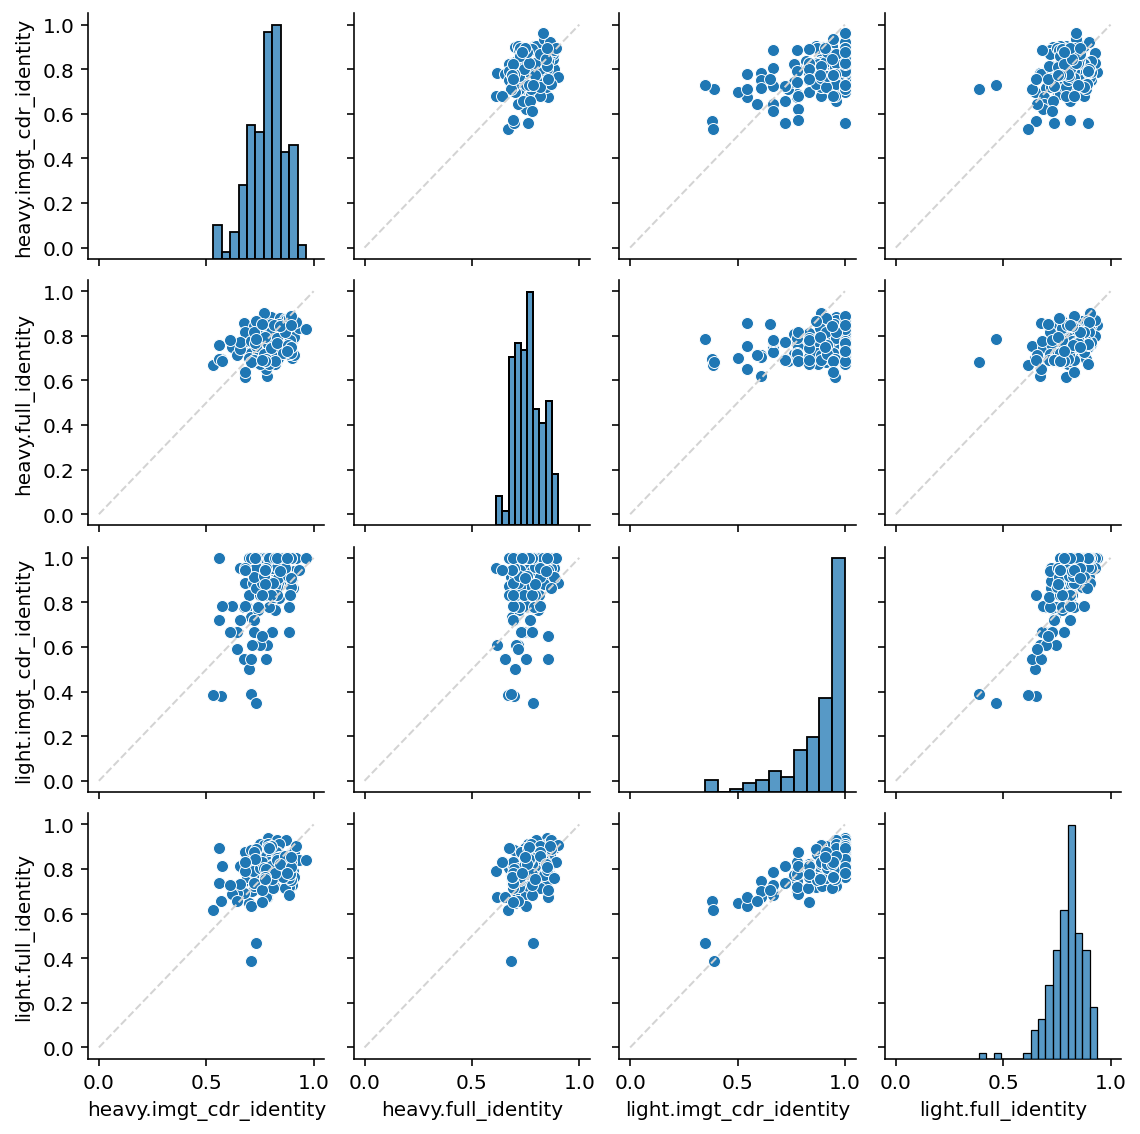

In [159]:
v = ['heavy.imgt_cdr_identity', 'heavy.full_identity', 'light.imgt_cdr_identity', 'light.full_identity']
g = sns.pairplot(data=hits, vars=v, height=2);

for i in range(len(v)):
    for j in range(len(v)):
        if i != j:
            g.axes[i][j].plot([0, 1], [0, 1], ls='--', lw=1, color='lightgrey');

# Comparing to 25 known parental sequences

In [3]:
expected_chains = Chain.from_fasta('../../data/tasks/humab_25_pairs/pairs/parental.fa', scheme='kabat', as_series=True)
expected_chains.head()

AntiCD28       ((H1, E), (H2, V), (H3, K), (H4, L), (H5, Q), ...
AntiCD28       ((L1, D), (L2, I), (L3, E), (L4, T), (L5, L), ...
Campath        ((H1, E), (H2, V), (H3, K), (H4, L), (H5, L), ...
Campath        ((L1, D), (L2, I), (L3, K), (L4, M), (L5, T), ...
Bevacizumab    ((H1, E), (H2, I), (H3, Q), (H4, L), (H5, V), ...
dtype: object

In [4]:
expected_heavy_chains = expected_chains[expected_chains.apply(lambda c: c.is_heavy_chain())]
expected_light_chains = expected_chains[expected_chains.apply(lambda c: c.is_light_chain())].loc[expected_heavy_chains.index]

In [162]:
known_index = expected_heavy_chains.index[expected_heavy_chains.index.isin(hits.index)].sort_values()
len(known_index), known_index

(22,
 Index(['Bevacizumab', 'Certolizumab', 'Clazakizumab', 'Crizanlizumab',
        'Eculizumab', 'Etaracizumab', 'Idarucizumab', 'Ixekizumab',
        'Ligelizumab', 'Lorvotuzumab', 'Mogamulizumab', 'Omalizumab',
        'Palivizumab', 'Pembrolizumab', 'Pertuzumab', 'Pinatuzumab',
        'Refanezumab', 'Reslizumab', 'Rovalpituzumab', 'Solanezumab',
        'Talacotuzumab', 'Tocilizumab'],
       dtype='object'))

In [6]:
def compare_expected_frameworks(query, expected, found, chain_label):
    expected_mutations = {pos: bb for pos, (aa, bb) in query.align(expected) if not pos.is_in_cdr() and aa != bb}
    found_mutations = {pos: bb for pos, (aa, bb) in query.align(found) if not pos.is_in_cdr() and aa != bb}
    
    mutated_positions = sorted(set(expected_mutations) | set(found_mutations))
    
    is_recovered = [expected_mutations.get(pos) == found_mutations.get(pos)
              for pos in mutated_positions]
    
    num_recovered = sum(is_recovered)
    accuracy = num_recovered / len(mutated_positions)
    
    aligned = expected.align(found)
    identity = 1 - (aligned.num_mutations() / len(aligned))
        
    print(f'{expected.name} {chain_label}: {num_recovered}/{len(mutated_positions)} recovered ({accuracy:.0%} accuracy, {identity:.0%} identity)')
    print(expected.align(query, found))
        
    return {
        'antibody': expected.name,
        'recovery_fw_accuracy': accuracy,
        'recovery_identity': identity,
        'chain_label': chain_label
    }

In [164]:
print('Expected')
print('↑↑↑↑↑')
print('Query')
print('↓↓↓↓↓')
print('Found')
print('')

accuracy = []

for query, expected, found in zip(query_heavy_chains.loc[known_index], expected_heavy_chains.loc[known_index], parental_heavy_chains.loc[known_index]):
    accuracy.append(compare_expected_frameworks(query, expected, found, chain_label='Heavy'))

for query, expected, found in zip(query_light_chains.loc[known_index], expected_light_chains.loc[known_index], parental_light_chains.loc[known_index]):
    accuracy.append(compare_expected_frameworks(query, expected, found, chain_label='Light'))

accuracy = pd.DataFrame(accuracy)

Expected
↑↑↑↑↑
Query
↓↓↓↓↓
Found

Bevacizumab Heavy: 22/31 recovered (71% accuracy, 93% identity)
EIQLVQSGPELKQPGETVRISCKASGYTFTNYGMNWVKQAPGKGLKWMGWINTYTGEPTYAADFKRRFTFSLETSASTAYLQISNLKNDDTATYFCAKYPHYYGSSHWYFDVWGAGTTVTVSS
|+|||+||..|.|||.++|+||.||||||||||||||+|||||||+|+||||||||||||||||||||||||+||.||||||+++|+.+|||.|+|||||||||||||||||||.||.|||||
EVQLVESGGGLVQPGGSLRLSCAASGYTFTNYGMNWVRQAPGKGLEWVGWINTYTGEPTYAADFKRRFTFSLDTSKSTAYLQMNSLRAEDTAVYYCAKYPHYYGSSHWYFDVWGQGTLVTVSS
++|||+||..|.+||.++++||.||||||||||||||||||||||+|+||||||||||||||||||||.|||+||.||||||+|+|+.||.|.|+||+||||||||||||||||.||.|||||
QIQLVQSGPELKKPGETVKISCKASGYTFTNYGMNWVRQAPGKGLKWMGWINTYTGEPTYAADFKRRFAFSLETSASTAYLQINNLKNEDMATYFCARYPHYYGSSHWYFDVWGAGTTVTVSS
 °                        °°°°^^^^^           °°°^^^^^^^^^^^^^^^^^ ° ° ° °    °                 °°^^^^^^^^^^^^^^°          
Certolizumab Heavy: 22/29 recovered (76% accuracy, 92% identity)
QIQLVQSGPELKKPGETVKISCKASGYVFTDYGMNWVKQAPGKAFKWMGWINTYIGEPIYVDDFKGRFAFSLETSASTAFLQINNLKNEDTAT

In [165]:
heavy_accuracy = accuracy[accuracy['chain_label'] == 'Heavy'].sort_values(by='recovery_fw_accuracy')
heavy_accuracy['index'] = heavy_accuracy['antibody'].apply(lambda a: f'{a} (nearest: {heavy_species.loc[a]})')
heavy_accuracy['hit_imgt_cdr_identity'] = heavy_hits['imgt_cdr_identity'].loc[heavy_accuracy['antibody']].values
heavy_accuracy['hit_imgt_fw_identity'] = heavy_hits['imgt_fw_identity'].loc[heavy_accuracy['antibody']].values
heavy_accuracy.head()

,antibody,recovery_fw_accuracy,recovery_identity,chain_label,index,hit_imgt_cdr_identity,hit_imgt_fw_identity
19,Solanezumab,0.050000,0.830357,Heavy,Solanezumab (nearest: Camel),0.720000,0.846154
2,Clazakizumab,0.225806,0.791667,Heavy,Clazakizumab (nearest: rabbit),0.700000,0.703297
10,Mogamulizumab,0.333333,0.882353,Heavy,Mogamulizumab (nearest: mouse),0.678571,0.857143
8,Ligelizumab,0.407407,0.853659,Heavy,Ligelizumab (nearest: mouse),0.718750,0.692308
12,Palivizumab,0.550000,0.925000,Heavy,Palivizumab (nearest: mouse),0.866667,0.802198


In [166]:
light_accuracy = accuracy[accuracy['chain_label'] == 'Light'].sort_values(by='recovery_fw_accuracy')
light_accuracy['index'] = light_accuracy['antibody'].apply(lambda a: f'{a} (nearest: {light_species.loc[a]})')
light_accuracy['hit_imgt_cdr_identity'] = light_hits['imgt_cdr_identity'].loc[light_accuracy['antibody']].values
light_accuracy['hit_imgt_fw_identity'] = light_hits['imgt_fw_identity'].loc[light_accuracy['antibody']].values
light_accuracy.head()

,antibody,recovery_fw_accuracy,recovery_identity,chain_label,index,hit_imgt_cdr_identity,hit_imgt_fw_identity
24,Clazakizumab,0.029412,0.700000,Light,Clazakizumab (nearest: mouse),0.500000,0.685393
39,Reslizumab,0.193548,0.766355,Light,Reslizumab (nearest: mouse),0.666667,0.685393
27,Etaracizumab,0.571429,0.841121,Light,Etaracizumab (nearest: mouse),0.888889,0.752809
41,Solanezumab,0.583333,0.955357,Light,Solanezumab (nearest: mouse),0.913043,0.865169
38,Refanezumab,0.611111,0.937500,Light,Refanezumab (nearest: mouse),1.000000,0.853933


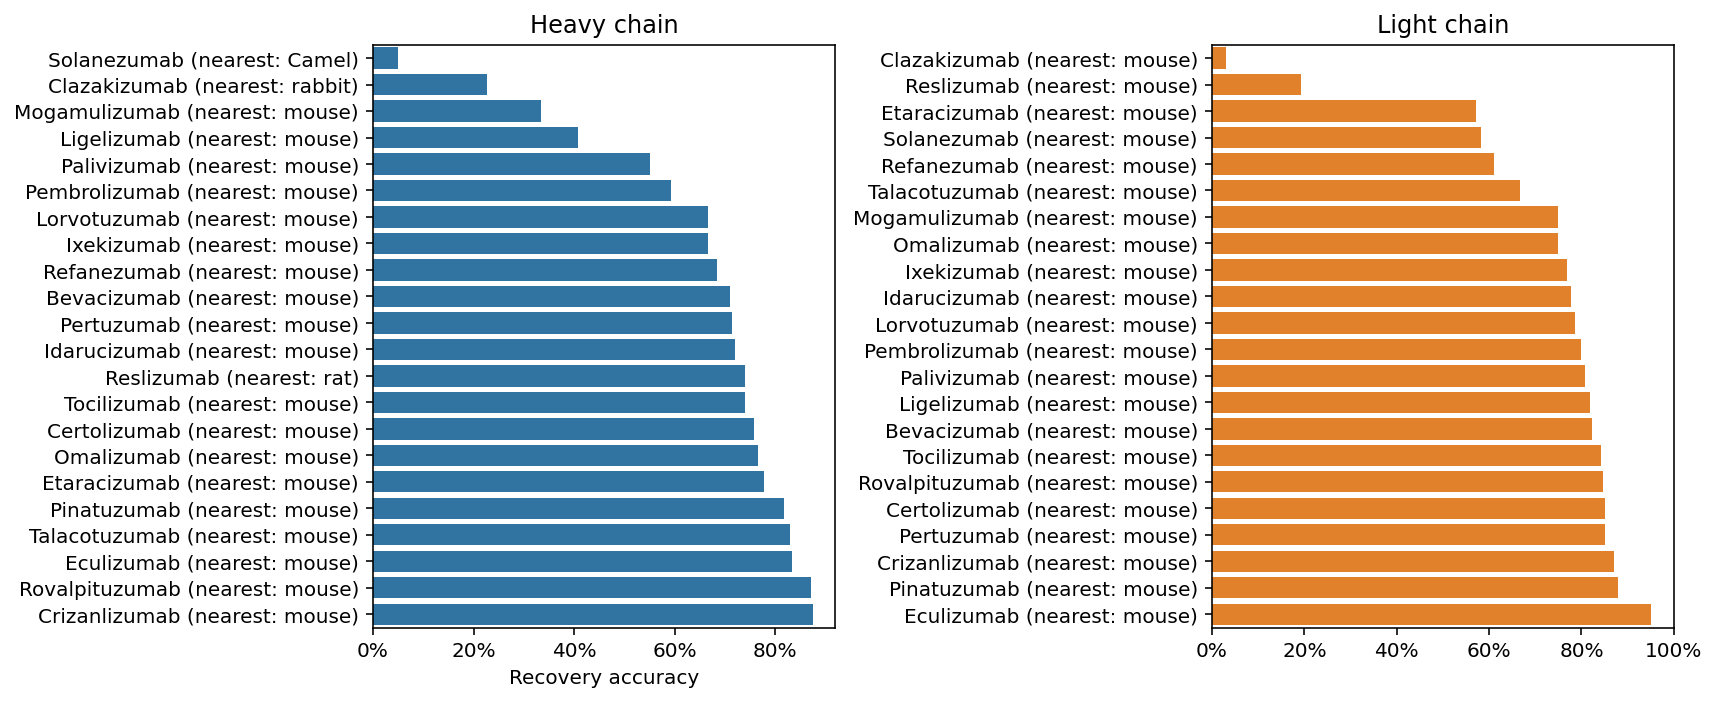

In [167]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5));

ax = sns.barplot(data=heavy_accuracy, x='recovery_fw_accuracy', y='index', color='tab:blue', ax=axes[0]);
ax.set_xlabel('Recovery accuracy')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.set_title('Heavy chain')
ax.set_ylabel('')

ax = sns.barplot(data=light_accuracy, x='recovery_fw_accuracy', y='index', color='tab:orange', ax=axes[1]);

ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.set_xlim(0, 1)
ax.set_xlabel('')
ax.set_title('Light chain')
ax.set_ylabel('')

fig.tight_layout();

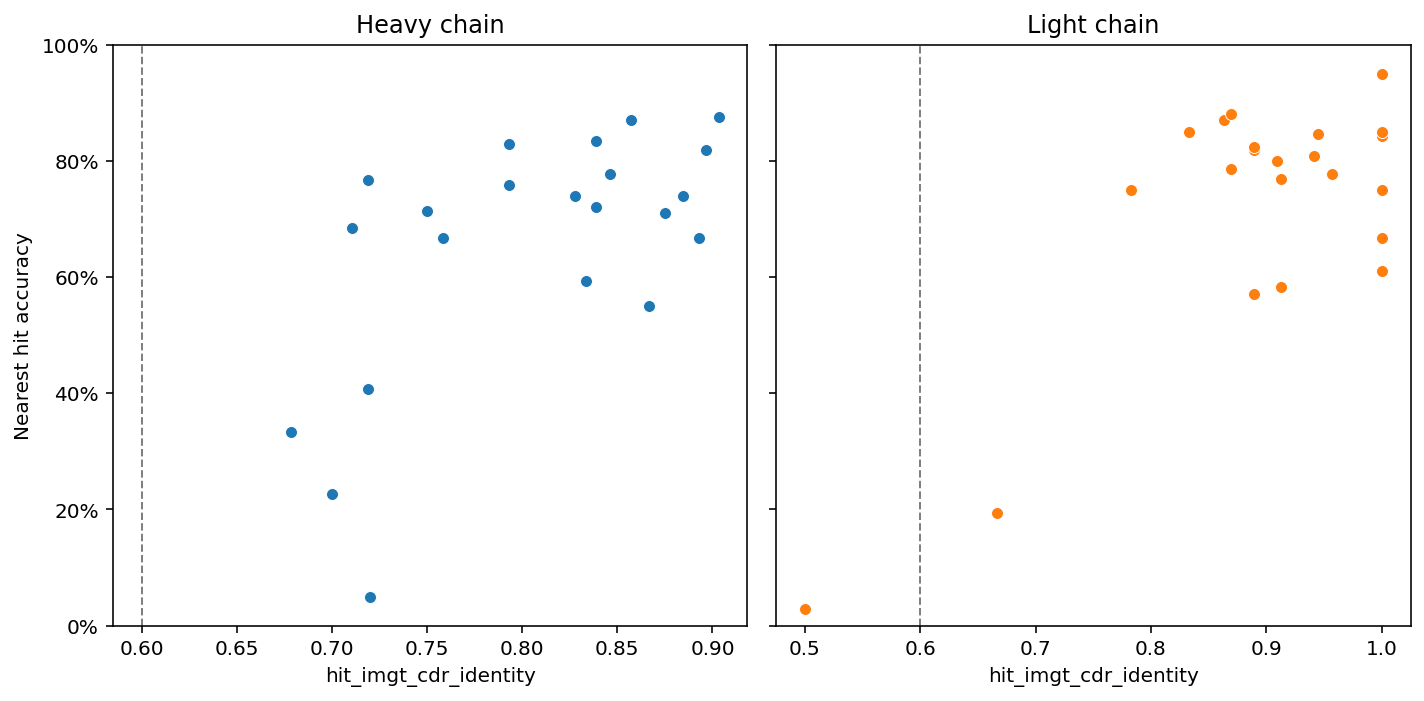

In [168]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True);

ax = sns.scatterplot(data=heavy_accuracy, y='recovery_fw_accuracy', x='hit_imgt_cdr_identity', color='tab:blue', ax=axes[0]);
ax.set_ylabel('Nearest hit accuracy')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.set_title('Heavy chain')
ax.axvline(MIN_IMGT_CDR_IDENTITY, ls='--', lw=1, color='grey')

ax = sns.scatterplot(data=light_accuracy, y='recovery_fw_accuracy', x='hit_imgt_cdr_identity', color='tab:orange', ax=axes[1]);

ax.set_ylim(0, 1)
ax.set_ylabel('')
ax.set_title('Light chain')
ax.axvline(MIN_IMGT_CDR_IDENTITY, ls='--', lw=1, color='grey')

fig.tight_layout();

In [169]:
heavy_accuracy.mean()

recovery_fw_accuracy     0.651274
recovery_identity        0.919238
hit_imgt_cdr_identity    0.804635
hit_imgt_fw_identity     0.733766
dtype: float64

In [170]:
light_accuracy.mean()

recovery_fw_accuracy     0.719339
recovery_identity        0.933773
hit_imgt_cdr_identity    0.892244
hit_imgt_fw_identity     0.789581
dtype: float64

In [174]:
heavy_accuracy[heavy_accuracy['antibody'].isin(keep_index)].mean()

recovery_fw_accuracy     0.671534
recovery_identity        0.925312
hit_imgt_cdr_identity    0.809618
hit_imgt_fw_identity     0.735217
dtype: float64

In [175]:
light_accuracy[light_accuracy['antibody'].isin(keep_index)].mean()

recovery_fw_accuracy     0.752192
recovery_identity        0.944906
hit_imgt_cdr_identity    0.910922
hit_imgt_fw_identity     0.794543
dtype: float64

In [171]:
heavy_accuracy.head(10)

,antibody,recovery_fw_accuracy,recovery_identity,chain_label,index,hit_imgt_cdr_identity,hit_imgt_fw_identity
19,Solanezumab,0.050000,0.830357,Heavy,Solanezumab (nearest: Camel),0.720000,0.846154
2,Clazakizumab,0.225806,0.791667,Heavy,Clazakizumab (nearest: rabbit),0.700000,0.703297
10,Mogamulizumab,0.333333,0.882353,Heavy,Mogamulizumab (nearest: mouse),0.678571,0.857143
8,Ligelizumab,0.407407,0.853659,Heavy,Ligelizumab (nearest: mouse),0.718750,0.692308
12,Palivizumab,0.550000,0.925000,Heavy,Palivizumab (nearest: mouse),0.866667,0.802198
13,Pembrolizumab,0.592593,0.908333,Heavy,Pembrolizumab (nearest: mouse),0.833333,0.703297
9,Lorvotuzumab,0.666667,0.949153,Heavy,Lorvotuzumab (nearest: mouse),0.892857,0.857143
7,Ixekizumab,0.666667,0.865546,Heavy,Ixekizumab (nearest: mouse),0.758621,0.703297
16,Refanezumab,0.684211,0.952381,Heavy,Refanezumab (nearest: mouse),0.710526,0.802198
0,Bevacizumab,0.709677,0.926829,Heavy,Bevacizumab (nearest: mouse),0.875000,0.681319


In [172]:
light_accuracy.head()

,antibody,recovery_fw_accuracy,recovery_identity,chain_label,index,hit_imgt_cdr_identity,hit_imgt_fw_identity
24,Clazakizumab,0.029412,0.700000,Light,Clazakizumab (nearest: mouse),0.500000,0.685393
39,Reslizumab,0.193548,0.766355,Light,Reslizumab (nearest: mouse),0.666667,0.685393
27,Etaracizumab,0.571429,0.841121,Light,Etaracizumab (nearest: mouse),0.888889,0.752809
41,Solanezumab,0.583333,0.955357,Light,Solanezumab (nearest: mouse),0.913043,0.865169
38,Refanezumab,0.611111,0.937500,Light,Refanezumab (nearest: mouse),1.000000,0.853933


- Clazakizumab: Rabbit
- Reslizumab: Mouse / Rat (?)

In [14]:
heavy_identities = []
for query, expected in zip(query_heavy_chains.loc[known_index], expected_heavy_chains.loc[known_index]):
    aligned = query.align(expected)
    heavy_identities.append(1 - (aligned.num_mutations() / len(aligned)))

np.mean(heavy_identities)

0.79502873238422

In [15]:
light_identities = []
for query, expected in zip(query_light_chains.loc[known_index], expected_light_chains.loc[known_index]):
    aligned = query.align(expected)
    light_identities.append(1 - (aligned.num_mutations() / len(aligned)))

np.mean(light_identities)

0.8229012645308955